# Regression Test Case Prioritization Using Machine Learning

# Introduction

**Abstract** : 

Regression testing is the common task of retesting software that has been changed or extended by new features during software development. And most of the time retesting the whole program is not feasible with reasonable time and cost, and to overcome only a subset of all test cases is executed for regression testing, e.g., by executing test cases according to test case prioritization.
There are a vast amount of methods for test case prioritization exist but they mostly require access to source code but in the actual scenario, it's difficult to get access to source code (i.e., black-box), so for an effective regression testing process, other information has to be employed. In this Proof of Concept (POC), we have referred multiple white papers and case studies on classification models present on this topic in the public domain and try to implement it in our way.

**Propsed Solution** : 

We will prioritize test cases for manual regression testing with the help of supervised machine learning. Our approach considers black-box meta-data, such as **test case history**, as well as **Natural Language test case descriptions for prioritization** and we will apply further machine learning algorithms and an ensemble learning approach. 

Also, we evaluate our approach on WPP Regression Test cases as test data which represent real life regression testing data set.

Below image will summarize the proposed solution

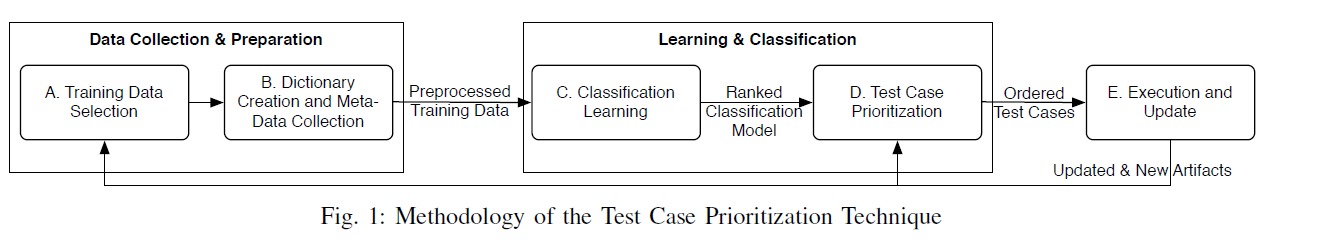

# Data Collection & Preparation

Let's start with data collection and preprocessing

To align with industry practice and get best results from this POC activity we have kept a limited number of features in our test data i.e. in regression test cases list we have kept only following fields as features of our training data

<a>**Test Case Description(TCD)**</a> : Title or description of test case

<a>**Priority**</a> : Priority of failed test cases

<a>**Target**</a> : Represent weather test cases should be selected or not in binary format

> **Note** :For the POC purpose we have used **Priority** to decide **Target** column values and kept all **Critical** and **High** priority test cases as selected i.e. **1** and all **Low** and **Medium** priority test cases as not selected i.e. **0**

In [10]:
#importing required libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

In [11]:
#Importing test case dump
dataset=pd.read_csv("TestCases_TestData.csv")

In [12]:
#Checking the number of records and columns
dataset.shape

(2127, 3)

In [13]:
#Checking data set
dataset.head()

,TCD,Priority,Target
0,Verify reprinting of QQ &WeChat info sheet aft...,Medium,0
1,Verify fallback info sheet print when QQ servi...,Medium,0
2,Verify printing of QQ and WeChat welcome page ...,Critical,1
3,Verify printing of info sheet after changing C...,Medium,0
4,Verify printing of info sheet after changing U...,Low,0


Let's create Corpus from 'TCD' coloumn, **Corpus** is a simplified version of our test case description data that contain clean text data. 

To create Corpus we have to perform the following actions

<ol>
    <li><b>Remove unwanted words</b>: Removal of unwanted words such as <a>special characters</a> and <a>numbers</a> to get only pure text. We will do it by specify our pattern using re library</li>
    <li><b>Transform words to lowercase</b>: Transform words to lowercase because upper and lower case have diffirent <a>ASCII</a> codes</li>
    <li><b>Remove stopwords</b>:Stop words are usually the most common words in a language and they will be irrelevant in determining the nature</li>
    <li><b>Stemming words</b>:Stemming is the process of reducing words to their word stem, base or root form. We use stemming to reduce Bag of Words dimensionality</li>
</ol>  

Now let's deal with our **TCD** column.

In [14]:
corpus  = []
pstem = PorterStemmer()
for i in range(dataset['TCD'].shape[0]):
    #Remove unwanted words
    text = re.sub("[^a-zA-Z]", ' ', dataset['TCD'][i])
    #Transform words to lowercase
    text = text.lower()
    text = text.split()
    #Remove stopwords then Stemming it
    text = [pstem.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    #Append cleaned tweet to corpus
    corpus.append(text)
    
print("Corpus created successfully") 

Corpus created successfully


In [15]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, -1].values

# Learning and Classification
Now we will build our models, we will use following models
* Gaussian Naive Bayes Model
* Multinomial Naive Bayes Model
* Decision Tree Model
* Gradient Boosting Model
* K - Nearest Neighbors Model

We will evaluate model based on confusion matrix , which is formed from the four outcomes produced as a result of binary classification

A binary classifier predicts all data instances of a test dataset as either positive or negative. This classification (or prediction) produces four outcomes – true positive, true negative, false positive and false negative.

* True positive (TP): correct positive prediction
* False positive (FP): incorrect positive prediction
* True negative (TN): correct negative prediction
* False negative (FN): incorrect negative prediction

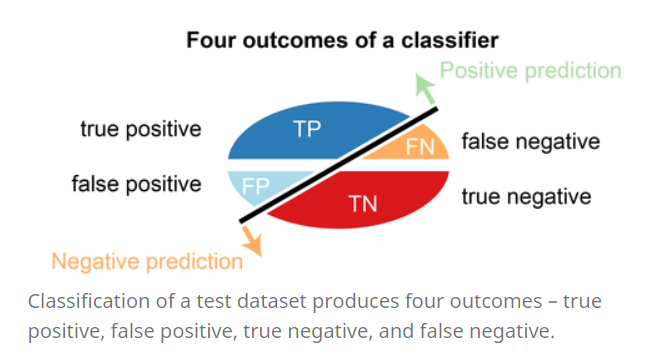

## Confusion matrix
A confusion matrix of binary classification is a two by two table formed by counting of the number of the four outcomes of a binary classifier. We usually denote them as TP, FP, TN, and FN instead of “the number of true positives”, and so on

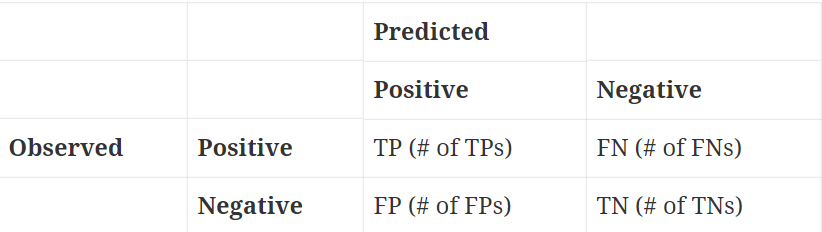

## Error Rate

Error rate (ERR) is calculated as the number of all incorrect predictions divided by the total number of the dataset. The best error rate is 0.0, whereas the worst is 1.0

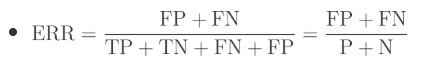

## Accuracy
Accuracy (ACC) is calculated as the number of all correct predictions divided by the total number of the dataset. The best accuracy is 1.0, whereas the worst is 0.0. It can also be calculated by 1 – ERR

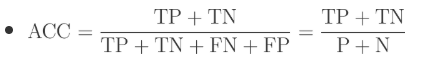

In [16]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## Gaussian Naive Bayes Model

In [17]:
# Fitting Gausian to the Training set
classifier_gnb = GaussianNB()
classifier_gnb.fit(X_train, y_train)
# Predicting the Test set results
y_pred_gnb = classifier_gnb.predict(X_test)
# Making the Confusion Matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
cm_gnb

array([[180,  49],
       [  5, 192]], dtype=int64)

In [18]:
#Calculating Model Accuracy
print('GaussianNB Classifier Accuracy Score is {} for Train Data Set'.format(classifier_gnb.score(X_train, y_train)))
print('GaussianNB Classifier Accuracy Score is {} for Test Data Set'.format(classifier_gnb.score(X_test, y_test)))
print('GaussianNB Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_gnb)))

GaussianNB Classifier Accuracy Score is 0.897119341563786 for Train Data Set
GaussianNB Classifier Accuracy Score is 0.8732394366197183 for Test Data Set
GaussianNB Classifier F1 Score is 0.8767123287671231


## Multinomial Naive Bayes Model

In [19]:
# Fitting Naive Bayes to the Training set
classifier_nb = MultinomialNB(alpha=0.1)
classifier_nb.fit(X_train, y_train)
# Predicting the Test set results
y_pred_nb = classifier_gnb.predict(X_test)
# Making the Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

In [20]:
#Calculating Model Accuracy
print('MultinomialNB Classifier Accuracy Score is {} for Train Data Set'.format(classifier_nb.score(X_train, y_train)))
print('MultinomialNB Classifier Accuracy Score is {} for Test Data Set'.format(classifier_nb.score(X_test, y_test)))
print('MultinomialNB Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_nb)))

MultinomialNB Classifier Accuracy Score is 0.8659611992945326 for Train Data Set
MultinomialNB Classifier Accuracy Score is 0.8403755868544601 for Test Data Set
MultinomialNB Classifier F1 Score is 0.8767123287671231


## Decision Tree Model

In [21]:
# Fitting Decision Tree Model to the Training set
classifier_dt = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=55)
classifier_dt.fit(X_train, y_train)
# Predicting the Test set results
y_pred_dt = classifier_dt.predict(X_test)
# Making the Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt

array([[217,  12],
       [ 16, 181]], dtype=int64)

In [22]:
#Calculating Model Accuracy
print('Decision Tree  Classifier Accuracy Score is {} for Train Data Set'.format(classifier_dt.score(X_train, y_train)))
print('Decision Tree Classifier Accuracy Score is {} for Test Data Set'.format(classifier_dt.score(X_test, y_test)))
print('Decision Tree Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_dt)))

Decision Tree  Classifier Accuracy Score is 0.9970605526161082 for Train Data Set
Decision Tree Classifier Accuracy Score is 0.9342723004694836 for Test Data Set
Decision Tree Classifier F1 Score is 0.9282051282051282


## Gradient Boosting Model

In [23]:
# Fitting Gradient Boosting Model to the Training set
classifier_gb = GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 100,
                                                   max_depth = 30,
                                                   random_state=55)
classifier_gb.fit(X_train, y_train)
# Predicting the Test set results
y_pred_gb = classifier_gb.predict(X_test)
# Making the Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_gb

array([[212,  17],
       [ 13, 184]], dtype=int64)

In [24]:
#Calculating Model Accuracy
print('Gradient Boosting  Classifier Accuracy Score is {} for Train Data Set'.format(classifier_gb.score(X_train, y_train)))
print('Gradient Boosting Classifier Accuracy Score is {} for Test Data Set'.format(classifier_gb.score(X_test, y_test)))
print('Gradient Boosting Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_gb)))

Gradient Boosting  Classifier Accuracy Score is 0.9964726631393298 for Train Data Set
Gradient Boosting Classifier Accuracy Score is 0.9295774647887324 for Test Data Set
Gradient Boosting Classifier F1 Score is 0.9246231155778896


## K - Nearest Neighbors Model

In [25]:
# Fitting K - Nearest Neighbors Model to the Training set
classifier_knn = KNeighborsClassifier(n_neighbors = 7,
                                       weights = 'distance',
                                      algorithm = 'brute')
classifier_knn.fit(X_train, y_train)
# Predicting the Test set results
y_pred_knn = classifier_knn.predict(X_test)
# Making the Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn

array([[200,  29],
       [  7, 190]], dtype=int64)

In [26]:
#Calculating Model Accuracy
print('KNN  Classifier Accuracy Score is {} for Train Data Set'.format(classifier_knn.score(X_train, y_train)))
print('KNN Accuracy Score is {} for Test Data Set'.format(classifier_knn.score(X_test, y_test)))
print('KNN Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_knn)))

KNN  Classifier Accuracy Score is 0.9970605526161082 for Train Data Set
KNN Accuracy Score is 0.9154929577464789 for Test Data Set
KNN Classifier F1 Score is 0.9134615384615384


# What's Next? - To Do's

- [ ] List of Features can be improved to train our model i.e for Metadata for test cases can be added like **Requirement Coverage** , **Failure Priority** , **Failure Age** , **Test Execution Cost**
- [x] Another section to evaluate models with different methods like **F1 Score**
- [ ]  Can add Ensembling and Stacking of models to for better model training
- [ ] Can take Subject Matter Expert's help for accurate **Target** column values which finally help in model training
- [ ]  Convert the code base to utility script for better ease of use
- [ ] Currently couple of classifier models are coming as close to 93% accuracy , but this may differ for different data set so with new data set again we need to check the model's efficiency